In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
# Imports...
import matplotlib.pyplot as plt

In [3]:
# get all data
sales_train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
item_cat = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")

# Introduction

Given the following data :
* sales_train.csv
* test.csv
* sample_submission.csv
* items.csv
* item_categories.csv
* shops.csv <br>

**The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.**

Data fields
* **ID** - an Id that represents a (Shop, Item) tuple within the test set
* **shop_id** - unique identifier of a shop
* **item_id** - unique identifier of a product
* **item_category_id** - unique identifier of item category
* **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
* **item_price** - current price of an item
* **date** - date in format dd/mm/yyyy
* **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* **item_name** - name of item
* **shop_name** - name of shop
* **item_category_name** - name of item category

# Overview of data
## Sales train

In [4]:
print(sales_train.head(10))
print()
print(sales_train.info())

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
5  10.01.2013               0       25     2564      349.00           1.0
6  02.01.2013               0       25     2565      549.00           1.0
7  04.01.2013               0       25     2572      239.00           1.0
8  11.01.2013               0       25     2572      299.00           1.0
9  03.01.2013               0       25     2573      299.00           3.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date      

## Items

In [5]:
print(items.head())
print()
print(items.head())

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40

## Item Categories

In [6]:
print(item_cat.head())
print()
print(item_cat.info())

        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None


## Shops

In [7]:
print(shops.head())
print()
print(shops.info())

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


## Check Null values
Conclusion: No value is missing or null.

In [8]:
print(sales_train.isnull().mean())
print()
print(items.isnull().mean())
print()
print(item_cat.isnull().mean())
print()
print(item_cat.isnull().mean())
print()
print(shops.isnull().mean())

date              0.0
date_block_num    0.0
shop_id           0.0
item_id           0.0
item_price        0.0
item_cnt_day      0.0
dtype: float64

item_name           0.0
item_id             0.0
item_category_id    0.0
dtype: float64

item_category_name    0.0
item_category_id      0.0
dtype: float64

item_category_name    0.0
item_category_id      0.0
dtype: float64

shop_name    0.0
shop_id      0.0
dtype: float64


## Let's see at how many different values we are dealing with
Conclusions:
1. There is no redundant item/item_category/shop id
1. There is no redundant item/item_category/shop name

In [9]:
print(items['item_id'].unique().size == items.shape[0])
print(items['item_name'].unique().size == items.shape[0])
print(item_cat['item_category_id'].unique().size == item_cat.shape[0])
print(item_cat['item_category_name'].unique().size == item_cat.shape[0])
print(shops['shop_id'].unique().size == shops.shape[0])

True
True
True
True
True


## Some high level analysis

In [10]:
# Average # of times an item is sold
print('Average of # of times an item is sold : ', sales_train.shape[0] / items.shape[0])

Average of # of times an item is sold :  132.42440234551196


In [11]:
sales_train['date'] = pd.to_datetime(sales_train['date'])
sales_train.set_index('date', inplace=True)
sales_train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-02-01,0,59,22154,999.00,1.0
2013-03-01,0,25,2552,899.00,1.0
2013-05-01,0,25,2552,899.00,-1.0
2013-06-01,0,25,2554,1709.05,1.0
2013-01-15,0,25,2555,1099.00,1.0


In [12]:
# Merge data
items_merged = pd.merge(items, item_cat, on='item_category_id')
sales_train_merged = pd.merge(sales_train, shops, on='shop_id')
sales_train_merged = pd.merge(sales_train_merged, items_merged, on='item_id')

In [13]:
items_merged.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD


In [14]:
sales_train_merged.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


## Visualization of sales per item_id

In [15]:
def visualize_monthly_cnt(item_id):
    filtered_df = sales_train[sales_train['item_id'] == item_id].copy()
    filtered_df['item_cnt_day'].resample('M').agg(['sum']).plot(color='blue',ls='-', legend=False, ylabel='montly cnt of item {}'.format(item_id))

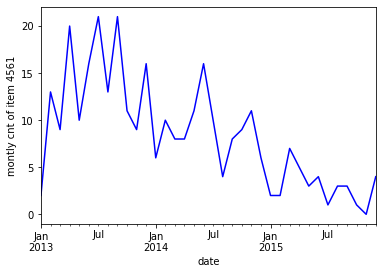

In [16]:
visualize_monthly_cnt(4561)